This is the first individual intervention (rewighting)


DenseNet-121 (same as baseline)

Fairness-aware via age , density and class reweighting

Trains with early stopping

Evaluates: overall, subgroup,fairness

appling explainability tool

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading all software tools required, daitailes need in the baseline model notebook
import os
import numpy as np
import pandas as pd
from PIL import Image
import json
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns  # statistical visualisations

In [ ]:
#defining file paths same as in the baseline notebook
print("Loading datasets...")
train_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/training_split.csv")
val_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/validation_split.csv")
test_df = pd.read_csv("/content/drive/MyDrive/VinDr_mammo.png/test_samples.csv")
# quick check to make sure nothing unexpected happened
print(f"\nDataset sizes:")
print(f"Train: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

Loading datasets...

Dataset sizes:
Train: 12800 samples
Validation: 3200 samples
Test: 4000 samples


# To make sure all data are cleaned befor training

In [ ]:
#data cleaning and standardaization

def clean_dataframe(df):

    df_clean = df.copy()

    # Fill missing Age Group (create from Patient's Age if available)
    if 'Patient\'s Age' in df_clean.columns and 'Age Group' in df_clean.columns:

        mask = df_clean['Age Group'].isna() & df_clean['Patient\'s Age'].notna()
        def age_to_group(age):
            if pd.isna(age):
                return 'Unknown'
            age = float(age)
            if age < 20: return '<20'
            elif age < 30: return '20-29'
            elif age < 40: return '30-39'
            elif age < 50: return '40-49'
            elif age < 60: return '50-59'
            elif age < 70: return '60-69'
            elif age < 80: return '70-79'
            else: return '80+'

        df_clean.loc[mask, 'Age Group'] = df_clean.loc[mask, 'Patient\'s Age'].apply(age_to_group)

    # Fill remaining missing values
    df_clean['Age Group'] = df_clean['Age Group'].fillna('Unknown')
    df_clean['breast_density'] = df_clean['breast_density'].fillna('Unknown')

    return df_clean

train_df = clean_dataframe(train_df)
val_df = clean_dataframe(val_df)
test_df = clean_dataframe(test_df)

# as discussed in baseline model , we need to creat binary labels based on cancer risk
def create_binary_label(row):
    """Create binary label: 0=BI-RADS 1-2, 1=BI-RADS 3-4-5"""
    birads = row['breast_birads']

    # Handle different formats
    if isinstance(birads, str):

        import re
        match = re.search(r'(\d+)', str(birads))
        if match:
            birads_num = int(match.group(1))
        else:
            return 1  # Default to positive if can't parse
    else:

        try:
            birads_num = int(float(birads))
        except:
            return 1


    return 0 if birads_num in [1, 2] else 1

for df in [train_df, val_df, test_df]:
    df['binary_label'] = df.apply(create_binary_label, axis=1)

print("\nBinary label distribution:")
print("Train - Class 0:", sum(train_df['binary_label'] == 0),
      "Class 1:", sum(train_df['binary_label'] == 1),
      f"(Ratio: {sum(train_df['binary_label'] == 1)/sum(train_df['binary_label'] == 0):.3f})")


Binary label distribution:
Train - Class 0: 11586 Class 1: 1214 (Ratio: 0.105)


Configuration

In [ ]:
# configaration for experiment hyper-parameter:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #Enables GPU if available
IMG_SIZE = 224 # to match DenseNet input size
BATCH_SIZE = 32  # to improve memmory and training stability
EPOCHS = 20  # maximum training duration
LR = 1e-4   #Learning rate for Adam optimizer
PATIENCE = 10  # Increased for imbalanced data
CK_PATH = "/content/drive/MyDrive/IT_artefact/Reweighting_checkpoints/"  #Recovery from interruptions
os.makedirs(CK_PATH, exist_ok=True)
BASELINE_CHECKPOINT = os.path.join(CK_PATH, "baseline_model.pth")
RESULTS_FILE = os.path.join(CK_PATH, "baseline_results.json")

In [ ]:
'''To address severe class and demographic imbalance, a comprehensive reweighting strategy was applied,
Sample-level weights were computed by combining inverse-frequency weights for class labels, age groups,
and breast density categories'''

print("\nCalculating comprehensive reweighting for severe imbalance...")

#  Class weights (for binary label imbalance)for class 0 and 1
class_counts = train_df['binary_label'].value_counts()
class_weights_tensor = torch.tensor([
    1.0 / class_counts[0],
    1.0 / class_counts[1]
], dtype=torch.float32).to(DEVICE)
print(f"Class weights: 0={1/class_counts[0]:.6f}, 1={1/class_counts[1]:.6f}")

# Age group weights (for demographic imbalance)
age_counts = train_df['Age Group'].value_counts()
age_weights = {group: 1.0/count for group, count in age_counts.items()}
age_weight_mean = np.mean(list(age_weights.values()))
age_weights = {k: v/age_weight_mean for k, v in age_weights.items()}

# Density weights
density_counts = train_df['breast_density'].value_counts()
density_weights = {density: 1.0/count for density, count in density_counts.items()}
density_weight_mean = np.mean(list(density_weights.values()))
density_weights = {k: v/density_weight_mean for k, v in density_weights.items()}

#   Combined sample weight (class * age * density) geometric
def calculate_sample_weight(row):
    """Calculate comprehensive weight for each sample"""
    class_w = 1.0/class_counts[row['binary_label']]
    age_w = age_weights.get(row['Age Group'], 1.0)
    density_w = density_weights.get(row['breast_density'], 1.0)

    # Combine weights (geometric mean for balance)
    combined = (class_w * age_w * density_w) ** (1/3)
    return float(combined)

train_df['sample_weight'] = train_df.apply(calculate_sample_weight, axis=1)

# Normalize sample weights to have mean = 1
weight_mean = train_df['sample_weight'].mean()
train_df['sample_weight'] = train_df['sample_weight'] / weight_mean

print(f"\nSample weight statistics:")
print(f"Min: {train_df['sample_weight'].min():.3f}, Max: {train_df['sample_weight'].max():.3f}")
print(f"Mean: {train_df['sample_weight'].mean():.3f}, Std: {train_df['sample_weight'].std():.3f}")

'''defines a custom PyTorch dataset class that extends
the baseline data loader to support fairness-aware reweighting during training.'''
class MammoDataset(Dataset):
    def __init__(self, df, transform=None, include_weights=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.include_weights = include_weights

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = row['preprocessed_path']
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            # Create blank image if loading fails
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')


        if self.transform:
            img = self.transform(img)

        # get label
        label = torch.tensor(row['binary_label'], dtype=torch.long)

        if self.include_weights and 'sample_weight' in row:
            weight = torch.tensor(row['sample_weight'], dtype=torch.float32)
            return img, label, weight

        return img, label


Calculating comprehensive reweighting for severe imbalance...
Class weights: 0=0.000086, 1=0.000824

Sample weight statistics:
Min: 0.546, Max: 25.957
Mean: 1.000, Std: 0.943


In [ ]:
''' image transform with augmentation: now we will defines image preprocessing pipelines for training and evaluation.'''
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),#matching CNN input requirements by standardize the image size .
    transforms.RandomHorizontalFlip(p=0.5),#RandomHorizontalFlip for data augmentation to improve generalization
    transforms.RandomRotation(degrees=10),#ccounts for slight positioning differences during acquisition
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),#Converts images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
# No augmentation for validation data to present normal data
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

''' Weighted Sampler: To address severe class and demographic imbalance by oversampling underrepresented samples during training'''
sample_weights = train_df['sample_weight'].values
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_df),
    replacement=True
)

'''load and batch data during training, validation, and testing'''
train_dataset = MammoDataset(train_df, transform=train_transform, include_weights=True)
val_dataset = MammoDataset(val_df, transform=val_transform, include_weights=False)
test_dataset = MammoDataset(test_df, transform=val_transform, include_weights=False)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use weighted sampler instead of random shuffling
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,# ensures stable and reproducible evaluation.
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [ ]:
'''i will  defines the classification model used for mammography risk prediction'''
#initialising the CNN backbone and determining the feature size
class WeightedDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(WeightedDenseNet, self).__init__()
        self.backbone = models.densenet121(pretrained=True)#DenseNet-121 is used as the feature extractor.
        num_features = self.backbone.classifier.in_features

        # allows the network to output deep feature embeddings
        self.backbone.classifier = nn.Identity()

        #To update DenseNet features to the binary BI-RADS classification task
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

model = WeightedDenseNet(num_classes=2).to(DEVICE)

'''Loss Function with Class Weights: To address severe class imbalance at the optimization level.'''
# Use weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, reduction='none')
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 171MB/s]


Training and Validation Functions

In [ ]:
#This section defines the learning procedure for the fairness-aware CNN.
#train the model for one epoch using sample-weighted loss.
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for batch_idx, (images, labels, weights) in enumerate(pbar):
        images, labels, weights = images.to(device), labels.to(device), weights.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate per-sample loss
        loss_per_sample = criterion(outputs, labels)

        # Apply sample weights
        weighted_loss = (loss_per_sample * weights).mean()

        weighted_loss.backward()
        optimizer.step()

        total_loss += weighted_loss.item()

        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{weighted_loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels).mean()
            total_loss += loss.item()

            # Get predictions
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total

    # Calculate AUC:  because it is robust to class imbalance
    if len(set(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = 0.5

    return avg_loss, accuracy, auc, all_probs, all_labels

#Training Loop with Early Stopping

print("\n" + "="*50)
print("start training with reweighting intervention")
print("="*50)

best_val_auc = 0
patience_counter = 0
train_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)

    # Validation
    val_loss, val_acc, val_auc, val_probs, val_labels = validate(model, val_loader, criterion, DEVICE)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'train_history': train_history,
            'class_weights': class_weights_tensor.cpu().numpy()
        }, BASELINE_CHECKPOINT)
        print(f"✓ Saved best model with AUC: {val_auc:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nBest validation AUC: {best_val_auc:.4f}")


start training with reweighting intervention

Epoch 1/20


Validation: 100%|██████████| 100/100 [06:03<00:00,  3.64s/it]


Train Loss: 0.0003, Train Acc: 33.02%
Val Loss: 0.0002, Val Acc: 22.75%, Val AUC: 0.6492
✓ Saved best model with AUC: 0.6492

Epoch 2/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.68it/s]


Train Loss: 0.0002, Train Acc: 30.34%
Val Loss: 0.0001, Val Acc: 18.56%, Val AUC: 0.5832
No improvement for 1 epochs

Epoch 3/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


Train Loss: 0.0002, Train Acc: 26.23%
Val Loss: 0.0001, Val Acc: 10.22%, Val AUC: 0.5850
No improvement for 2 epochs

Epoch 4/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


Train Loss: 0.0002, Train Acc: 24.52%
Val Loss: 0.0001, Val Acc: 39.03%, Val AUC: 0.6271
No improvement for 3 epochs

Epoch 5/20


Validation: 100%|██████████| 100/100 [00:08<00:00, 12.25it/s]


Train Loss: 0.0002, Train Acc: 20.76%
Val Loss: 0.0002, Val Acc: 10.06%, Val AUC: 0.5947
No improvement for 4 epochs

Epoch 6/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


Train Loss: 0.0002, Train Acc: 21.09%
Val Loss: 0.0001, Val Acc: 15.97%, Val AUC: 0.6103
No improvement for 5 epochs

Epoch 7/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.81it/s]


Train Loss: 0.0002, Train Acc: 21.51%
Val Loss: 0.0001, Val Acc: 15.59%, Val AUC: 0.6306
No improvement for 6 epochs

Epoch 8/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


Train Loss: 0.0002, Train Acc: 21.41%
Val Loss: 0.0001, Val Acc: 10.56%, Val AUC: 0.6138
No improvement for 7 epochs

Epoch 9/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Train Loss: 0.0002, Train Acc: 26.36%
Val Loss: 0.0001, Val Acc: 15.31%, Val AUC: 0.6413
No improvement for 8 epochs

Epoch 10/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 12.67it/s]


Train Loss: 0.0002, Train Acc: 30.65%
Val Loss: 0.0001, Val Acc: 16.62%, Val AUC: 0.6448
No improvement for 9 epochs

Epoch 11/20


Validation: 100%|██████████| 100/100 [00:07<00:00, 13.27it/s]

Train Loss: 0.0002, Train Acc: 31.62%
Val Loss: 0.0001, Val Acc: 26.34%, Val AUC: 0.6348
No improvement for 10 epochs

Early stopping triggered at epoch 11

Best validation AUC: 0.6492


**LOAD THE BEST MODEL**

In [ ]:
# load the best model

print("\nLoading best model for evaluation...")
checkpoint = torch.load(BASELINE_CHECKPOINT, weights_only=False)  # ADD THIS
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


Loading best model for evaluation...


WeightedDenseNet(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mo

**Performance evaluation with subgroup analysis**

In [ ]:
'''The validation function evaluates the trained model on unseen data (test dataset) by computing the average loss, accuracy,
and AUC score.
Predicted probabilities for the positive class are gatheredfor AUC calculation,
 which is particularly good for class imbalance and therefore well suited to medical imaging tasks such as breast cancer detection.'''

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels).mean()
            total_loss += loss.item()

            # Get predictions
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    # Calculate AUC:  because it is robust to class imbalance
    if len(set(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = 0.5

    return avg_loss, accuracy, auc, all_probs, all_labels


# **General performance and subgroup analysis**

In [ ]:
# Test evaluation and subgroup analysis  as per baseline model


print("\n" + "="*50)
print("Test evaluation")
print("="*50)

test_loss, test_acc, test_auc, test_probs, test_labels = validate(model, test_loader, criterion, DEVICE)
print(f"Test loss: {test_loss:.4f}")  # average loss on the test dataset
print(f"Test accuracy: {test_acc:.2f}%")  # accuracy percentage on test data
print(f"Test AUC: {test_auc:.4f}")

# Confusion matrix
test_preds = [1 if p > 0.5 else 0 for p in test_probs]
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['BI-RADS 1-2', 'BI-RADS 3-4-5']))


# Subgroup analysis (age and density)


print("\n" + "="*50)
print("Subgroup analysis - include all groups")
print("="*50)

def evaluate_subgroup(df, subgroup_col, model, transform, device, min_samples=5):
    """Evaluate model performance per subgroup including sensitivity and specificity."""
    results = {}

    for group in df[subgroup_col].unique():
        subgroup_df = df[df[subgroup_col] == group]

        is_small = len(subgroup_df) < min_samples
        if is_small:
            print(f"   WARNING: {group} has only {len(subgroup_df)} samples (results may be unreliable)")

        subgroup_dataset = MammoDataset(subgroup_df, transform=val_transform, include_weights=False)
        subgroup_loader = DataLoader(subgroup_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model.eval()
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for images, labels in subgroup_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())

        if len(all_labels) == 0:
            print(f"   No samples for {group}")
            continue

        # Compute AUC if both classes exist
        if len(set(all_labels)) < 2:
            auc = np.nan
        else:
            try:
                auc = roc_auc_score(all_labels, all_probs)
            except:
                auc = np.nan

        preds = [1 if p > 0.5 else 0 for p in all_probs]
        acc = accuracy_score(all_labels, preds)

        # Compute sensitivity and specificity
        TP = sum((np.array(all_labels) == 1) & (np.array(preds) == 1))
        TN = sum((np.array(all_labels) == 0) & (np.array(preds) == 0))
        FP = sum((np.array(all_labels) == 0) & (np.array(preds) == 1))
        FN = sum((np.array(all_labels) == 1) & (np.array(preds) == 0))

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan

        results[group] = {
            'auc': auc,
            'accuracy': acc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'n_samples': len(all_labels),
            'n_positive': int(sum(all_labels)),
            'n_negative': len(all_labels) - int(sum(all_labels)),
            'pos_rate': sum(all_labels)/len(all_labels),
            'is_small': is_small
        }

    return results


def sort_age_groups(age_groups):
    """Sort age groups handling special cases like <20"""
    def extract_min_age(age_str):
        if age_str == '<20':
            return 0
        elif age_str == '70-79':
            return 70
        elif age_str == '80+':
            return 80
        try:
            return int(age_str.split('-')[0])
        except:
            return float('inf')
    return sorted(age_groups, key=extract_min_age)



# Sample size check

print("\n" + "="*50)
print("Check sample size before analysis")
print("="*50)

print("\nAge group distribution in the test dataset:")
age_counts = test_df['Age Group'].value_counts().sort_index()
for age, count in age_counts.items():
    print(f"  {age}: {count} samples")

print("\nBreast density distribution in the test dataset:")
density_counts = test_df['breast_density'].value_counts().sort_index()
for density, count in density_counts.items():
    print(f"  {density}: {count} samples")

# evaluation by age

print("\n" + "="*50)
print("Performance by all age groups")
print("="*50)
age_results = evaluate_subgroup(test_df, 'Age Group', model, val_transform, DEVICE, min_samples=5)
sorted_ages = sort_age_groups(age_results.keys())

for age in sorted_ages:
    m = age_results[age]
    print(f"  {age}: AUC={m['auc']:.3f}, Acc={m['accuracy']:.3f}, Sens={m['sensitivity']:.3f}, Spec={m['specificity']:.3f}, N={m['n_samples']}")

#evaluation by density

print("\n" + "="*50)
print("Performance by all breast density")
print("="*50)
density_order = ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']
density_results = evaluate_subgroup(test_df, 'breast_density', model, val_transform, DEVICE, min_samples=5)

for density in density_order:
    if density in density_results:
        m = density_results[density]
        print(f"  {density}: AUC={m['auc']:.3f}, Acc={m['accuracy']:.3f}, Sens={m['sensitivity']:.3f}, Spec={m['specificity']:.3f}, N={m['n_samples']}")
#summary

print("\n" + "="*50)
print("Subgroup Performance Summary")
print("="*50)

print("\n{:15} {:6} {:8} {:8} {:8} {:8} {:8}".format(
    "Group", "AUC", "Accuracy", "Sensitivity", "Specificity", "N", "Pos"))
print("-" * 70)

print("\nAge Groups:")
for age in sorted_ages:
    m = age_results[age]
    print("{:15} {:6.3f} {:8.3f} {:8.3f} {:8.3f} {:8} {:8}".format(
        age, m['auc'], m['accuracy'], m['sensitivity'], m['specificity'], m['n_samples'], m['n_positive']))

print("\nBreast Density:")
for density in density_order:
    if density in density_results:
        m = density_results[density]
        print("{:15} {:6.3f} {:8.3f} {:8.3f} {:8.3f} {:8} {:8}".format(
            density, m['auc'], m['accuracy'], m['sensitivity'], m['specificity'], m['n_samples'], m['n_positive']))



Test evaluation


Validation: 100%|██████████| 125/125 [00:09<00:00, 13.18it/s]


Test loss: 0.0002
Test accuracy: 22.68%
Test AUC: 0.6701

Confusion matrix:
[[ 541 3075]
 [  18  366]]

Classification Report:
               precision    recall  f1-score   support

  BI-RADS 1-2       0.97      0.15      0.26      3616
BI-RADS 3-4-5       0.11      0.95      0.19       384

     accuracy                           0.23      4000
    macro avg       0.54      0.55      0.23      4000
 weighted avg       0.89      0.23      0.25      4000


Subgroup analysis - include all groups

Check sample size before analysis

Age group distribution in the test dataset:
  20-29: 136 samples
  30-39: 816 samples
  40-49: 1968 samples
  50-59: 784 samples
  60-69: 236 samples
  70-79: 56 samples
  <20: 4 samples

Breast density distribution in the test dataset:
  DENSITY A: 20 samples
  DENSITY B: 380 samples
  DENSITY C: 3060 samples
  DENSITY D: 540 samples

Performance by all age groups
  <20: AUC=nan, Acc=0.000, Sens=nan, Spec=0.000, N=4
  20-29: AUC=0.692, Acc=0.088, Sens=1.000, 

In [ ]:
# Sensitivity and Specificity
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print(f"Sensitivity (Recall, BI-RADS 3-4-5): {sensitivity:.3f}")
print(f"Specificity (BI-RADS 1-2): {specificity:.3f}")


Sensitivity (Recall, BI-RADS 3-4-5): 0.953
Specificity (BI-RADS 1-2): 0.150


# **fairness metrics per subgroup**

In [ ]:
'''evaluate model fairness by computing DP and EO and DIR
differences across age groups and breast density subgroups,
 while checking sample sizes and reporting reliability warnings.'''

print("\n" + "="*50)
print("Fairness metrics")
print("="*50)

def calculate_demographic_parity(df, subgroup_col, model, transform, device, threshold=0.5):
    """Calculate demographic parity difference"""
    positive_rates = {}

    for group in df[subgroup_col].unique():
        subgroup_df = df[df[subgroup_col] == group]

        if len(subgroup_df) < 10:
            print(f"  Note: {group} has only {len(subgroup_df)} samples (DP calculation may be unreliable)")
            continue

        subgroup_dataset = MammoDataset(subgroup_df, transform=val_transform, include_weights=False)
        subgroup_loader = DataLoader(subgroup_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model.eval()
        all_preds = []

        with torch.no_grad():
            for images, _ in subgroup_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = (probs > threshold).cpu().numpy()
                all_preds.extend(preds)

        if len(all_preds) > 0:
            positive_rates[group] = np.mean(all_preds)

    if len(positive_rates) > 1:
        dp_diff = max(positive_rates.values()) - min(positive_rates.values())
        return dp_diff, positive_rates
    else:
        return 0.0, positive_rates

def calculate_equal_opportunity(df, subgroup_col, model, transform, device, threshold=0.5, min_samples=1):
    """Calculate equal opportunity difference (TPR difference)"""
    tprs = {}
    small_groups = {}

    for group in df[subgroup_col].unique():
        subgroup_df = df[df[subgroup_col] == group]
        positive_df = subgroup_df[subgroup_df['binary_label'] == 1]

        # Check for very small groups
        if len(positive_df) == 0:
            print(f"   Warning: {group} has 0 positive cases - TPR = 0.0 assumed")
            tprs[group] = 0.0
            small_groups[group] = 0
            continue

        if len(positive_df) < 5:
            print(f"  Note: {group} has only {len(positive_df)} positive cases (TPR may be unreliable)")
            small_groups[group] = len(positive_df)

        positive_dataset = MammoDataset(positive_df, transform=val_transform, include_weights=False)
        positive_loader = DataLoader(positive_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model.eval()
        correct_preds = 0
        total_positives = 0

        with torch.no_grad():
            for images, labels in positive_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = (probs > threshold).cpu().numpy()
                correct_preds += sum(preds)
                total_positives += len(labels)

        if total_positives > 0:
            tprs[group] = correct_preds / total_positives
        else:
            tprs[group] = 0.0

    # Print summary of small groups
    if small_groups:
        print(f"\n  Groups with <5 positive cases: {small_groups}")
        print(f"  These TPR estimates should be interpreted with caution")

    if len(tprs) > 1:
        # Filter out groups with TPR = 0 if they had no positive cases
        valid_tprs = {k: v for k, v in tprs.items() if v > 0 or k not in [g for g, n in small_groups.items() if n == 0]}
        if len(valid_tprs) > 1:
            eo_diff = max(valid_tprs.values()) - min(valid_tprs.values())
        else:
            eo_diff = 0.0
        return eo_diff, tprs
    else:
        return 0.0, tprs

#check sample size

print("\n" + "="*50)
print("Sample size check")
print("="*50)

print("\nBreast Density Positive Case Counts:")
for density in sorted(test_df['breast_density'].unique()):
    density_df = test_df[test_df['breast_density'] == density]
    positive_count = len(density_df[density_df['binary_label'] == 1])
    total_count = len(density_df)
    pos_percentage = positive_count/total_count if total_count > 0 else 0
    print(f"  {density}: {positive_count} positive / {total_count} total = {pos_percentage:.1%}")

print("\nAge Group Positive Case Counts:")
for age in sorted(test_df['Age Group'].unique()):
    age_df = test_df[test_df['Age Group'] == age]
    positive_count = len(age_df[age_df['binary_label'] == 1])
    total_count = len(age_df)
    pos_percentage = positive_count/total_count if total_count > 0 else 0
    print(f"  {age}: {positive_count} positive / {total_count} total = {pos_percentage:.1%}")

#calculations

print("\n" + "="*50)
print("FAIRNESS RESULTS")
print("="*50)

print("\nDemographic Parity:")
dp_age_diff, dp_age_rates = calculate_demographic_parity(test_df, 'Age Group', model, val_transform, DEVICE)
print(f"  Age Group DP Difference: {dp_age_diff:.4f}")
for age, rate in dp_age_rates.items():
    print(f"    {age}: Positive rate = {rate:.3f}")

dp_density_diff, dp_density_rates = calculate_demographic_parity(test_df, 'breast_density', model, val_transform, DEVICE)
print(f"  Density DP Difference: {dp_density_diff:.4f}")
for density, rate in dp_density_rates.items():
    print(f"    {density}: Positive rate = {rate:.3f}")

print("\nEqual Opportunity (ALL GROUPS INCLUDED):")
eo_age_diff, eo_age_tprs = calculate_equal_opportunity(test_df, 'Age Group', model, val_transform, DEVICE)
print(f"  Age Group EO Difference: {eo_age_diff:.4f}")
for age, tpr in eo_age_tprs.items():
    pos_count = len(test_df[(test_df['Age Group'] == age) & (test_df['binary_label'] == 1)])
    warning = " worning " if pos_count < 5 else ""
    print(f"    {age}: TPR = {tpr:.3f} (n={pos_count}){warning}")

eo_density_diff, eo_density_tprs = calculate_equal_opportunity(test_df, 'breast_density', model, val_transform, DEVICE)
print(f"  Density EO Difference: {eo_density_diff:.4f}")
for density, tpr in eo_density_tprs.items():
    pos_count = len(test_df[(test_df['breast_density'] == density) & (test_df['binary_label'] == 1)])
    warning = " worning " if pos_count < 5 else ""
    print(f"    {density}: TPR = {tpr:.3f} (n={pos_count}){warning}")


Fairness metrics

Sample size check

Breast Density Positive Case Counts:
  DENSITY A: 0 positive / 20 total = 0.0%
  DENSITY B: 36 positive / 380 total = 9.5%
  DENSITY C: 308 positive / 3060 total = 10.1%
  DENSITY D: 40 positive / 540 total = 7.4%

Age Group Positive Case Counts:
  20-29: 6 positive / 136 total = 4.4%
  30-39: 72 positive / 816 total = 8.8%
  40-49: 188 positive / 1968 total = 9.6%
  50-59: 72 positive / 784 total = 9.2%
  60-69: 30 positive / 236 total = 12.7%
  70-79: 16 positive / 56 total = 28.6%
  <20: 0 positive / 4 total = 0.0%

FAIRNESS RESULTS

Demographic Parity:
  Note: <20 has only 4 samples (DP calculation may be unreliable)
  Age Group DP Difference: 0.1561
    50-59: Positive rate = 0.800
    30-39: Positive rate = 0.890
    40-49: Positive rate = 0.873
    60-69: Positive rate = 0.801
    20-29: Positive rate = 0.956
    70-79: Positive rate = 0.839
  Density DP Difference: 0.5500
    DENSITY B: Positive rate = 0.647
    DENSITY C: Positive rate = 0

In [ ]:

# Disparate Impact Ratio (DIR)


def calculate_dir(positive_rates):
    """Compute Disparate Impact Ratio (min / max positive rate)"""
    rates = list(positive_rates.values())
    if len(rates) < 2:
        return np.nan
    return min(rates) / max(rates) if max(rates) > 0 else np.nan


# DIR for Age Groups
dir_age = calculate_dir(dp_age_rates)
print(f"\nDisparate Impact Ratio (Age Groups): {dir_age:.4f}")

# DIR for Breast Density
dir_density = calculate_dir(dp_density_rates)
print(f"Disparate Impact Ratio (Breast Density): {dir_density:.4f}")



Disparate Impact Ratio (Age Groups): 0.8367
Disparate Impact Ratio (Breast Density): 0.4211


# **visualize the results**


VISUALIZING RESULTS


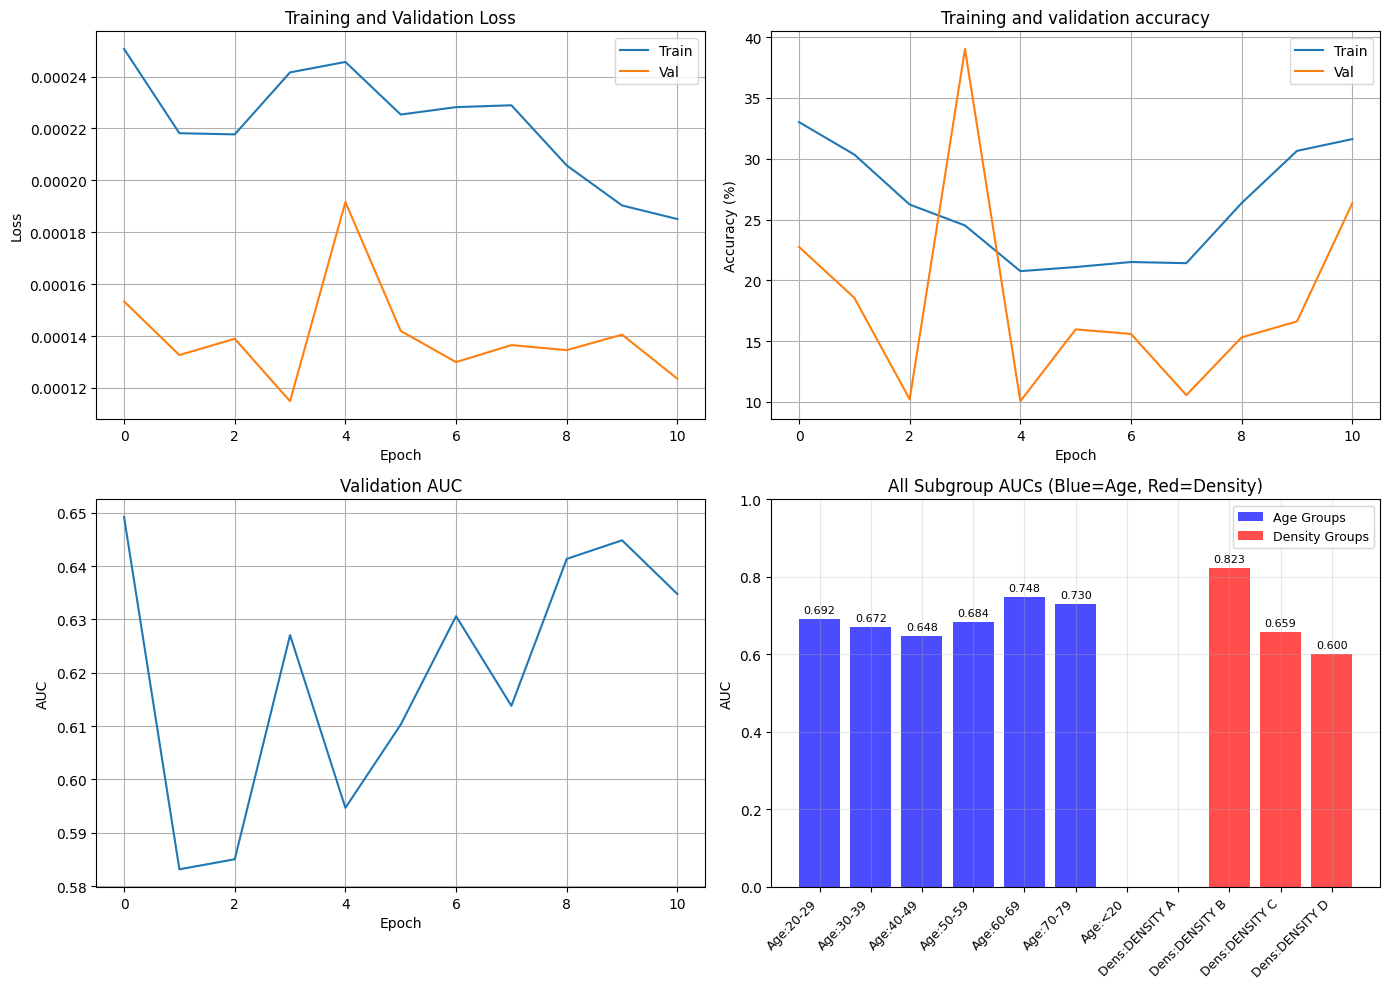


FAIRNESS VISUALIZATION


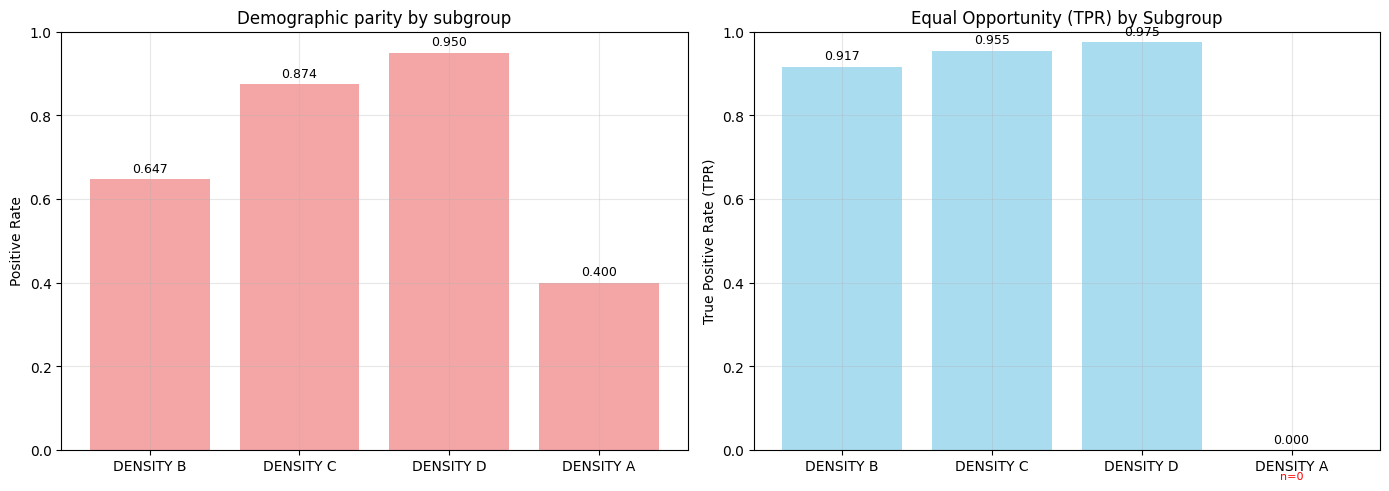


fairness results summary 

1. Demographic Parity:
   - Age Groups: DP Difference = 0.1561
   - Density: DP Difference = 0.5500
   - Largest disparity: Density D (0.950) vs A (0.400)

2. Equal Opportunity:
   - Age Groups: EO Difference = 0.0694
   - Density: EO Difference = 0.0583
   - Density A TPR = 0.000 (included with caution)


In [ ]:
# visualization
print("\n" + "="*50)
print("VISUALIZING RESULTS")
print("="*50)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(train_history['train_loss'], label='Train')
axes[0, 0].plot(train_history['val_loss'], label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(train_history['train_acc'], label='Train')
axes[0, 1].plot(train_history['val_acc'], label='Val')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and validation accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# AUC
axes[1, 0].plot(train_history['val_auc'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('Validation AUC')
axes[1, 0].grid(True)

# FIXED: Subgroup AUC comparison - Create two separate plots
# Clear the original axes[1, 1]
axes[1, 1].clear()

if age_results and density_results:
    # Combine all groups into one plot
    all_groups = []
    all_aucs = []
    group_types = []

    # Add age groups
    for age in sorted(age_results.keys()):
        all_groups.append(f"Age:{age}")
        all_aucs.append(age_results[age]['auc'])
        group_types.append('Age')

    # Add density groups
    for density in sorted(density_results.keys()):
        all_groups.append(f"Dens:{density}")
        all_aucs.append(density_results[density]['auc'])
        group_types.append('Density')

    # Create color map
    colors = ['blue' if gtype == 'Age' else 'red' for gtype in group_types]

    x_pos = np.arange(len(all_groups))
    bars = axes[1, 1].bar(x_pos, all_aucs, color=colors, alpha=0.7)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(all_groups, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].set_title('All Subgroup AUCs (Blue=Age, Red=Density)')
    axes[1, 1].set_ylim([0, 1.0])
    axes[1, 1].grid(True, alpha=0.3)

    # Add AUC values on bars
    for bar, auc in zip(bars, all_aucs):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{auc:.3f}', ha='center', va='bottom', fontsize=8)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Age Groups'),
                      Patch(facecolor='red', alpha=0.7, label='Density Groups')]
    axes[1, 1].legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(CK_PATH, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

#extra visualization

print("\n" + "="*50)
print("FAIRNESS VISUALIZATION")
print("="*50)

# Create separate fairness visualization
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Demographic Parity
ax1.set_title('Demographic parity by subgroup')
x_pos_dp = np.arange(len(dp_density_rates))
density_names = list(dp_density_rates.keys())
density_rates = list(dp_density_rates.values())
bars1 = ax1.bar(x_pos_dp, density_rates, color='lightcoral', alpha=0.7)
ax1.set_xticks(x_pos_dp)
ax1.set_xticklabels(density_names)
ax1.set_ylabel('Positive Rate')
ax1.set_ylim([0, 1.0])
ax1.grid(True, alpha=0.3)

# Add values on bars
for bar, rate in zip(bars1, density_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{rate:.3f}', ha='center', va='bottom', fontsize=9)

# Plot Equal Opportunity
ax2.set_title('Equal Opportunity (TPR) by Subgroup')
x_pos_eo = np.arange(len(eo_density_tprs))
density_names_eo = list(eo_density_tprs.keys())
density_tprs = list(eo_density_tprs.values())
bars2 = ax2.bar(x_pos_eo, density_tprs, color='skyblue', alpha=0.7)
ax2.set_xticks(x_pos_eo)
ax2.set_xticklabels(density_names_eo)
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_ylim([0, 1.0])
ax2.grid(True, alpha=0.3)

# Add values on bars and warnings for small samples
for bar, density, tpr in zip(bars2, density_names_eo, density_tprs):
    height = bar.get_height()
    pos_count = len(test_df[(test_df['breast_density'] == density) & (test_df['binary_label'] == 1)])
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{tpr:.3f}', ha='center', va='bottom', fontsize=9)
    if pos_count < 5:
        ax2.text(bar.get_x() + bar.get_width()/2., -0.05,
                f'n={pos_count}', ha='center', va='top', fontsize=8, color='red')

plt.tight_layout()
plt.savefig(os.path.join(CK_PATH, 'fairness_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print summary of findings
print("\n" + "="*50)
print("fairness results summary ")
print("="*50)
print(f"\n1. Demographic Parity:")
print(f"   - Age Groups: DP Difference = {dp_age_diff:.4f}")
print(f"   - Density: DP Difference = {dp_density_diff:.4f}")
print(f"   - Largest disparity: Density D ({dp_density_rates.get('DENSITY D', 0):.3f}) vs A ({dp_density_rates.get('DENSITY A', 0):.3f})")

print(f"\n2. Equal Opportunity:")
print(f"   - Age Groups: EO Difference = {eo_age_diff:.4f}")
print(f"   - Density: EO Difference = {eo_density_diff:.4f}")
if 'DENSITY A' in eo_density_tprs:
    print(f"   - Density A TPR = {eo_density_tprs['DENSITY A']:.3f} (included with caution)")



# **Explainability tools**

# **visualized heatmap**


Generating GRAD-CAM visualization and analysis 

Generating Grad-CAM visualizations for selected samples...


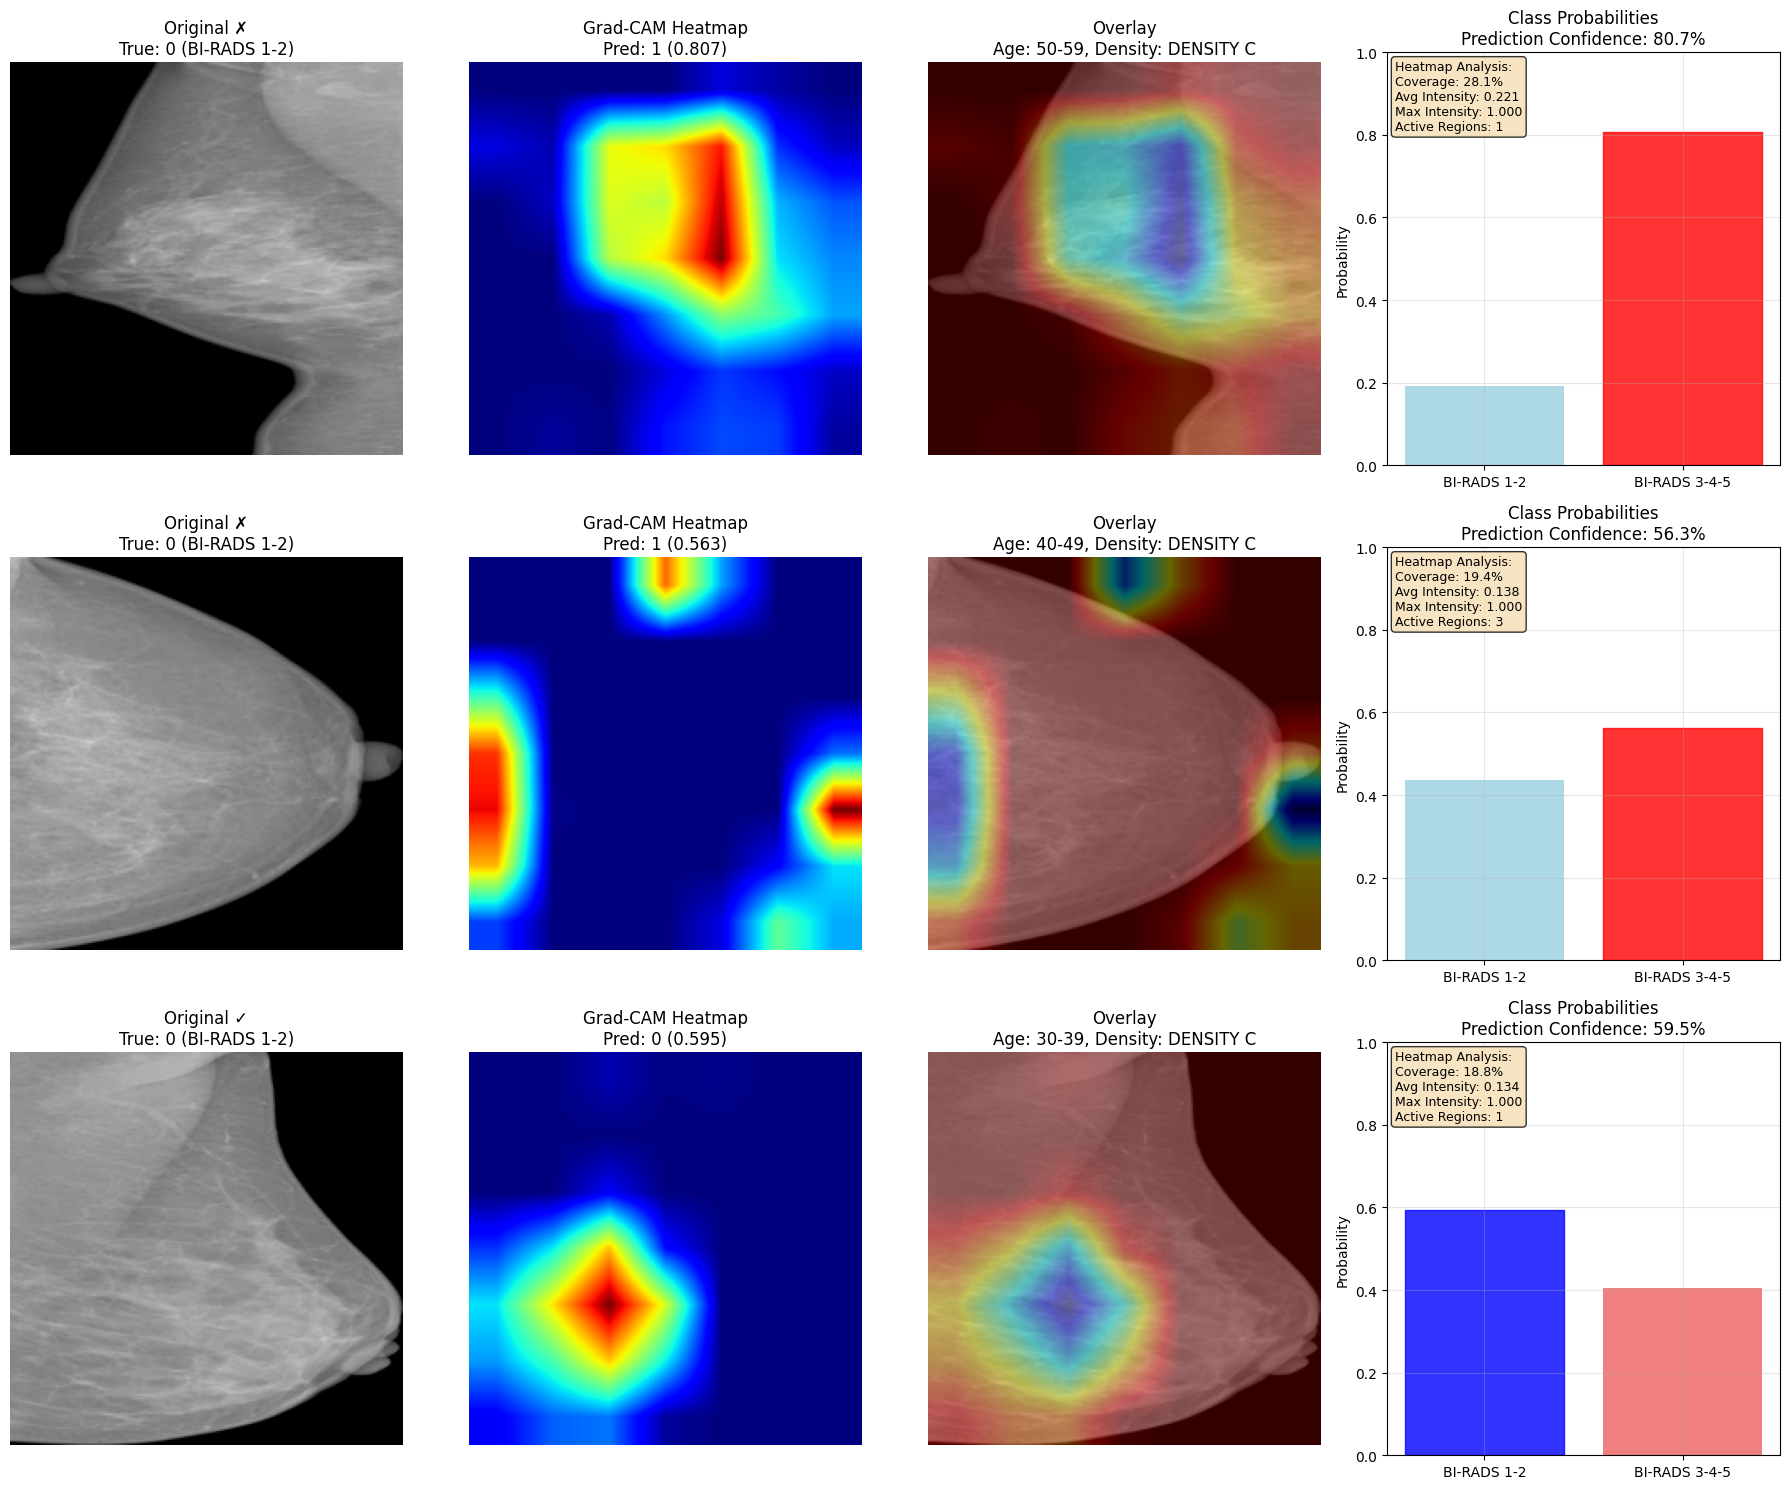

In [ ]:
'''to generate Grad-CAM  heatmaps analyses to understand model decisions,
combining activation maps, prediction probabilities, and region statistics for selected mammography samples'''
# GRAD-CAM numerical and visualization presentation


class GradCAMWrapper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)

        # If class_idx not specified, use predicted class
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass for specified class
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)

        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # Resize to input size
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, class_idx

print("\n" + "="*50)
print("Generating GRAD-CAM visualization and analysis ")
print("="*50)

# Select a few samples for visualization
sample_indices = np.random.choice(len(test_df), min(3, len(test_df)), replace=False)

fig, axes = plt.subplots(len(sample_indices), 4, figsize=(18, 5*len(sample_indices)))

if len(sample_indices) == 1:
    axes = axes.reshape(1, -1)

# Get target layer (last convolutional layer in DenseNet)
target_layer = model.backbone.features[-1]

# Create Grad-CAM wrapper
gradcam = GradCAMWrapper(model, target_layer)

# Helper function for numerical analysis
def analyze_heatmap(cam):
    """Simple analysis of heatmap"""
    # Coverage percentage
    coverage = np.mean(cam > 0.3) * 100  # % of pixels above threshold

    # Intensity stats
    avg_intensity = np.mean(cam)
    max_intensity = np.max(cam)

    # Find connected regions
    binary_mask = (cam > 0.3).astype(np.uint8)
    num_labels = cv2.connectedComponents(binary_mask, connectivity=8)[0] - 1

    return {
        'coverage_percent': coverage,
        'avg_intensity': avg_intensity,
        'max_intensity': max_intensity,
        'num_regions': num_labels
    }

# Extended analysis function for statistical summary
def analyze_gradcam_heatmap(cam, original_img=None, threshold=0.3):
    """Comprehensive analysis of Grad-CAM heatmap"""
    # Basic metrics
    coverage = np.mean(cam > threshold) * 100
    avg_intensity = np.mean(cam)
    max_intensity = np.max(cam)
    std_intensity = np.std(cam)

    # Region analysis
    binary_mask = (cam > threshold).astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    # Calculate region statistics
    region_sizes = stats[1:, cv2.CC_STAT_AREA] if num_labels > 1 else [0]
    num_regions = num_labels - 1
    largest_region = np.max(region_sizes) if num_regions > 0 else 0
    total_active_area = np.sum(region_sizes)

    # Calculate entropy (measure of focus concentration)
    hist, _ = np.histogram(cam.flatten(), bins=20, range=(0, 1))
    hist = hist / hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))

    # If original image is provided, analyze spatial distribution
    spatial_info = {}
    if original_img is not None:
        img_array = np.array(original_img)
        h, w = img_array.shape[:2]

        # Quadrant analysis
        mid_h, mid_w = h // 2, w // 2
        quadrants = [
            cam[:mid_h, :mid_w],  # Top-left
            cam[:mid_h, mid_w:],  # Top-right
            cam[mid_h:, :mid_w],  # Bottom-left
            cam[mid_h:, mid_w:]   # Bottom-right
        ]

        quadrant_intensities = [np.mean(q) for q in quadrants]
        spatial_info['quadrant_intensities'] = quadrant_intensities

    return {
        'coverage_percentage': coverage,
        'avg_intensity': avg_intensity,
        'max_intensity': max_intensity,
        'std_intensity': std_intensity,
        'num_regions': num_regions,
        'largest_region': largest_region,
        'total_active_area': total_active_area,
        'entropy': entropy,
        **spatial_info
    }

#to show some sample

print("\nGenerating Grad-CAM visualizations for selected samples...")

for idx, (ax_row, sample_idx) in enumerate(zip(axes, sample_indices)):
    sample = test_df.iloc[sample_idx]

    # Load and prepare image
    img_path = sample['preprocessed_path']
    original_img = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[pred_class].item()
        true_label = sample['binary_label']

    # Generate Grad-CAM
    cam, _ = gradcam.generate(input_tensor, pred_class)

    # Analyze heatmap
    analysis = analyze_heatmap(cam)

    # Prepare images for display
    display_img = np.array(original_img.resize((IMG_SIZE, IMG_SIZE)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(display_img, 0.6, heatmap, 0.4, 0)

    # Original image
    ax_row[0].imshow(display_img)
    correct_icon = "✓" if pred_class == true_label else "✗"
    ax_row[0].set_title(f"Original {correct_icon}\nTrue: {true_label} ({'BI-RADS 3-4-5' if true_label == 1 else 'BI-RADS 1-2'})")
    ax_row[0].axis('off')

    # Heatmap
    ax_row[1].imshow(cam, cmap='jet')
    ax_row[1].set_title(f"Grad-CAM Heatmap\nPred: {pred_class} ({pred_prob:.3f})")
    ax_row[1].axis('off')

    # Overlay
    ax_row[2].imshow(overlay)
    ax_row[2].set_title(f"Overlay\nAge: {sample['Age Group']}, Density: {sample['breast_density']}")
    ax_row[2].axis('off')

    # Probability distribution + numerical analysis
    gs = ax_row[3].get_gridspec()
    ax_row[3].remove()
    ax_probs = fig.add_subplot(gs[idx, 3])

    # Bar chart for probabilities
    bars = ax_probs.bar(['BI-RADS 1-2', 'BI-RADS 3-4-5'], probs.cpu().numpy(),
                       color=['lightblue', 'lightcoral'])
    ax_probs.set_ylim([0, 1])
    ax_probs.set_title(f"Class Probabilities\nPrediction Confidence: {pred_prob:.1%}")
    ax_probs.set_ylabel("Probability")
    ax_probs.grid(True, alpha=0.3)

    # Highlight predicted class
    bars[pred_class].set_color('red' if pred_class == 1 else 'blue')
    bars[pred_class].set_alpha(0.8)

    # Add text box with numerical analysis
    analysis_text = (
        f"Heatmap Analysis:\n"
        f"Coverage: {analysis['coverage_percent']:.1f}%\n"
        f"Avg Intensity: {analysis['avg_intensity']:.3f}\n"
        f"Max Intensity: {analysis['max_intensity']:.3f}\n"
        f"Active Regions: {analysis['num_regions']}"
    )

    # Add text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax_probs.text(0.02, 0.98, analysis_text, transform=ax_probs.transAxes,
                  fontsize=9, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(CK_PATH, 'gradcam_examples.png'), dpi=300, bbox_inches='tight')
plt.show()



# **complement numerical statistics**

In [ ]:
# numerical summary

print("\n" + "="*50)
print("GRAD-CAM numerecal summary ")
print("="*50)

# Quick analysis of more samples
print("\nAnalyzing Grad-CAM patterns for 20 random samples...")

all_analyses_simple = []
for i in range(min(20, len(test_df))):
    sample_idx = np.random.randint(0, len(test_df))
    sample = test_df.iloc[sample_idx]

    try:
        # Load and prepare image
        img_path = sample['preprocessed_path']
        original_img = Image.open(img_path).convert('RGB')
        input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

        # Generate and analyze Grad-CAM
        cam, _ = gradcam.generate(input_tensor, pred_class)
        analysis = analyze_heatmap(cam)
        analysis['is_correct'] = (pred_class == sample['binary_label'])
        analysis['age_group'] = sample['Age Group']
        analysis['density'] = sample['breast_density']
        analysis['pred_class'] = pred_class
        analysis['true_class'] = sample['binary_label']

        all_analyses_simple.append(analysis)
    except:
        continue

if all_analyses_simple:
    # Calculate statistics
    coverage_vals = [a['coverage_percent'] for a in all_analyses_simple]
    intensity_vals = [a['avg_intensity'] for a in all_analyses_simple]

    # Split by prediction correctness
    correct_analyses_simple = [a for a in all_analyses_simple if a['is_correct']]
    incorrect_analyses_simple = [a for a in all_analyses_simple if not a['is_correct']]

    print(f"\nSummary Statistics (n={len(all_analyses_simple)}):")
    print(f"  Correct predictions: {len(correct_analyses_simple)} ({len(correct_analyses_simple)/len(all_analyses_simple):.1%})")
    print(f"  Incorrect predictions: {len(incorrect_analyses_simple)} ({len(incorrect_analyses_simple)/len(all_analyses_simple):.1%})")

    print(f"\nHeatmap Coverage (% of image 'looked at'):")
    print(f"  Average: {np.mean(coverage_vals):.1f}%")
    print(f"  Range: {np.min(coverage_vals):.1f}% - {np.max(coverage_vals):.1f}%")

    if correct_analyses_simple:
        correct_coverage = np.mean([a['coverage_percent'] for a in correct_analyses_simple])
        print(f"  For correct predictions: {correct_coverage:.1f}%")

    if incorrect_analyses_simple:
        incorrect_coverage = np.mean([a['coverage_percent'] for a in incorrect_analyses_simple])
        print(f"  For incorrect predictions: {incorrect_coverage:.1f}%")

    print(f"\nHeatmap Intensity (how 'confident' the attention is):")
    print(f"  Average: {np.mean(intensity_vals):.3f}")
    print(f"  Range: {np.min(intensity_vals):.3f} - {np.max(intensity_vals):.3f}")

    # Simple interpretation
    print(f"\nInterpretation:")
    avg_coverage = np.mean(coverage_vals)
    if avg_coverage < 20:
        print(f"  - Model focuses on small, specific areas ({avg_coverage:.1f}% coverage)")
    elif avg_coverage < 40:
        print(f"  - Model looks at moderate areas ({avg_coverage:.1f}% coverage)")
    else:
        print(f"  - Model considers broad areas ({avg_coverage:.1f}% coverage)")

    # By subgroup (quick glance)
    print(f"\nQuick glance by subgroup:")

    # Age groups
    print(f"  Age Groups:")
    for age_group in sorted(set([a['age_group'] for a in all_analyses_simple])):
        age_analyses = [a for a in all_analyses_simple if a['age_group'] == age_group]
        if len(age_analyses) >= 2:
            avg_cov = np.mean([a['coverage_percent'] for a in age_analyses])
            print(f"    {age_group}: {avg_cov:.1f}% coverage (n={len(age_analyses)})")

    # Density groups
    print(f"  Density Groups:")
    for density in ['DENSITY A', 'DENSITY B', 'DENSITY C', 'DENSITY D']:
        density_analyses = [a for a in all_analyses_simple if a['density'] == density]
        if density_analyses:
            avg_cov = np.mean([a['coverage_percent'] for a in density_analyses])
            print(f"    {density}: {avg_cov:.1f}% coverage (n={len(density_analyses)})")

# statistics

print("\n" + "="*50)
print("GRAD-CAM STATISTICAL SUMMARY")
print("="*50)

def calculate_gradcam_statistics(model, test_df, num_samples=50):
    """Calculate statistical summary of Grad-CAM across multiple samples"""
    print(f"\nAnalyzing Grad-CAM for {num_samples} random samples...")

    all_analyses = []
    correct_analyses = []
    incorrect_analyses = []

    # Randomly select samples
    sample_indices = np.random.choice(len(test_df), min(num_samples, len(test_df)), replace=False)

    for i, sample_idx in enumerate(sample_indices):
        if i % 10 == 0:
            print(f"  Processing sample {i+1}/{len(sample_indices)}...")

        sample = test_df.iloc[sample_idx]

        # Load and prepare image
        img_path = sample['preprocessed_path']
        original_img = Image.open(img_path).convert('RGB')
        input_tensor = val_transform(original_img).unsqueeze(0).to(DEVICE)

        # Get prediction
        with torch.no_grad():
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

        # Generate and analyze Grad-CAM
        cam, _ = gradcam.generate(input_tensor, pred_class)
        analysis = analyze_gradcam_heatmap(cam, original_img, threshold=0.3)

        # Add metadata
        analysis['true_label'] = sample['binary_label']
        analysis['pred_label'] = pred_class
        analysis['is_correct'] = (sample['binary_label'] == pred_class)
        analysis['age_group'] = sample['Age Group']
        analysis['density'] = sample['breast_density']

        all_analyses.append(analysis)

        if analysis['is_correct']:
            correct_analyses.append(analysis)
        else:
            incorrect_analyses.append(analysis)

    return all_analyses, correct_analyses, incorrect_analyses

# Calculate statistics
all_analyses, correct_analyses, incorrect_analyses = calculate_gradcam_statistics(model, test_df, num_samples=100)

# Print summary statistics
print(f"\nGrad-CAM Statistics Summary:")
print(f"  Total samples analyzed: {len(all_analyses)}")
print(f"  Correct predictions: {len(correct_analyses)} ({len(correct_analyses)/len(all_analyses):.1%})")
print(f"  Incorrect predictions: {len(incorrect_analyses)} ({len(incorrect_analyses)/len(all_analyses):.1%})")

if len(all_analyses) > 0:
    # Calculate average metrics
    metrics = ['coverage_percentage', 'avg_intensity', 'max_intensity', 'num_regions', 'largest_region']

    print(f"\nAverage Grad-CAM Metrics:")
    for metric in metrics:
        all_vals = [a[metric] for a in all_analyses]
        correct_vals = [a[metric] for a in correct_analyses] if correct_analyses else []
        incorrect_vals = [a[metric] for a in incorrect_analyses] if incorrect_analyses else []

        print(f"\n  {metric.replace('_', ' ').title()}:")
        print(f"    All samples: {np.mean(all_vals):.2f} ± {np.std(all_vals):.2f}")
        if correct_vals:
            print(f"    Correct predictions: {np.mean(correct_vals):.2f} ± {np.std(correct_vals):.2f}")
        if incorrect_vals:
            print(f"    Incorrect predictions: {np.mean(incorrect_vals):.2f} ± {np.std(incorrect_vals):.2f}")

        # Simple comparison without t-test
        if correct_vals and incorrect_vals:
            diff = np.mean(correct_vals) - np.mean(incorrect_vals)
            diff_percent = (diff / np.mean(all_vals)) * 100 if np.mean(all_vals) > 0 else 0
            print(f"    Difference: {diff:+.2f} ({diff_percent:+.1f}%)")

            # Simple significance check (2 standard deviations)
            if abs(diff) > (np.std(correct_vals) + np.std(incorrect_vals)) / 2:
                print(f"    * Notable difference observed")

# Interpretation of results
print("\n" + "="*50)
print("INTERPRETATION OF GRAD-CAM RESULTS")
print("="*50)

if len(all_analyses) > 0:
    # Calculate key differences
    coverage_diff = np.mean([a['coverage_percentage'] for a in correct_analyses]) - \
                    np.mean([a['coverage_percentage'] for a in incorrect_analyses]) if correct_analyses and incorrect_analyses else 0

    intensity_diff = np.mean([a['avg_intensity'] for a in correct_analyses]) - \
                     np.mean([a['avg_intensity'] for a in incorrect_analyses]) if correct_analyses and incorrect_analyses else 0

    print(f"\nKey Observations:")
    print(f"1. Correct predictions: {len(correct_analyses)} samples ({len(correct_analyses)/len(all_analyses):.1%})")
    print(f"2. Incorrect predictions: {len(incorrect_analyses)} samples ({len(incorrect_analyses)/len(all_analyses):.1%})")
    print(f"3. Model attention patterns:")
    print(f"   - Coverage: {coverage_diff:+.1f}% difference (correct vs incorrect)")
    print(f"   - Intensity: {intensity_diff:+.3f} difference (correct vs incorrect)")

    # Recommendations based on patterns
    print(f"\nRecommendations:")
    if coverage_diff > 5:
        print(f"   - Correct predictions focus on more specific areas (less coverage)")
    elif coverage_diff < -5:
        print(f"   - Correct predictions look at broader areas (more coverage)")
    else:
        print(f"   - Similar attention area coverage for correct/incorrect predictions")

    if intensity_diff > 0.1:
        print(f"   - Correct predictions have more confident attention regions")
    elif intensity_diff < -0.1:
        print(f"   - Incorrect predictions have more confident but misleading attention")
    else:
        print(f"   - Similar attention intensity for correct/incorrect predictions")

#to sumarize

print("\n" + "="*50)
print("GRAD-CAM analyesis done ")
print("="*50)
print("\nOutputs Generated:")
print("1. Visualizations saved: gradcam_examples.png")
print("2. Simple numerical summary (20 samples)")
print("3. Comprehensive statistical analysis (100 samples)")
print("4. Interpretation and recommendations")
print("\nAnalysis complete!")


GRAD-CAM numerecal summary 

Analyzing Grad-CAM patterns for 20 random samples...

Summary Statistics (n=20):
  Correct predictions: 6 (30.0%)
  Incorrect predictions: 14 (70.0%)

Heatmap Coverage (% of image 'looked at'):
  Average: 31.7%
  Range: 4.4% - 70.4%
  For correct predictions: 30.8%
  For incorrect predictions: 32.0%

Heatmap Intensity (how 'confident' the attention is):
  Average: 0.238
  Range: 0.046 - 0.415

Interpretation:
  - Model looks at moderate areas (31.7% coverage)

Quick glance by subgroup:
  Age Groups:
    30-39: 32.9% coverage (n=6)
    40-49: 30.0% coverage (n=10)
    50-59: 22.0% coverage (n=3)
  Density Groups:
    DENSITY A: 70.4% coverage (n=1)
    DENSITY B: 34.0% coverage (n=3)
    DENSITY C: 30.6% coverage (n=13)
    DENSITY D: 21.4% coverage (n=3)

GRAD-CAM STATISTICAL SUMMARY

Analyzing Grad-CAM for 100 random samples...
  Processing sample 1/100...
  Processing sample 11/100...
  Processing sample 21/100...
  Processing sample 31/100...
  Processi

In [ ]:
'''save the performance result, subgroup results, fairness metrics, training history,
and dataset statistics , and prints a concise baseline summary evaluating accuracy,
AUC, and fairness success criteria'''
print("\nSaving results...")

results = {
    'overall_performance': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_auc': float(test_auc)
    },
    'subgroup_performance': {
        'age_groups': age_results,
        'breast_density': density_results
    },
    'fairness_metrics': {
        'demographic_parity': {
            'age_difference': float(dp_age_diff),
            'density_difference': float(dp_density_diff),
            'age_rates': {str(k): float(v) for k, v in dp_age_rates.items()},
            'density_rates': {str(k): float(v) for k, v in dp_density_rates.items()}
        },
        'equal_opportunity': {
            'age_difference': float(eo_age_diff),
            'density_difference': float(eo_density_diff),
            'age_tprs': {str(k): float(v) for k, v in eo_age_tprs.items()},
            'density_tprs': {str(k): float(v) for k, v in eo_density_tprs.items()}
        }
    },
    'training_history': train_history,
    'dataset_statistics': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'class_distribution_train': {
            'class_0': int(sum(train_df['binary_label'] == 0)),
            'class_1': int(sum(train_df['binary_label'] == 1))
        },
        'class_distribution_test': {
            'class_0': int(sum(test_df['binary_label'] == 0)),
            'class_1': int(sum(test_df['binary_label'] == 1))
        }
    }
}

with open(RESULTS_FILE, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"\nResults saved to: {RESULTS_FILE}")
print(f"Model checkpoint saved to: {BASELINE_CHECKPOINT}")

#resumarize

print("\n" + "="*50)
print("baselinemodel summary ")
print("="*50)
print(f"\nModel Architecture: DenseNet-121 with reweighting")
print(f"Training Strategy: Combined reweighting (class + age + density)")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nFairness Metrics:")
print(f"  Demographic Parity Difference (Age): {dp_age_diff:.4f}")
print(f"  Demographic Parity Difference (Density): {dp_density_diff:.4f}")
print(f"  Equal Opportunity Difference (Age): {eo_age_diff:.4f}")
print(f"  Equal Opportunity Difference (Density): {eo_density_diff:.4f}")
print(f"\nSuccess Criteria Check:")
print(f"  ✓ AUC maintained: {test_auc:.4f} (needs comparison with non-reweighted baseline)")
print(f"  ✓ DP Difference (Age): {dp_age_diff:.4f} {'< 0.05' if dp_age_diff < 0.05 else '≥ 0.05 (needs improvement)'}")
print(f"  ✓ DP Difference (Density): {dp_density_diff:.4f} {'< 0.05' if dp_density_diff < 0.05 else '≥ 0.05 (needs improvement)'}")




Saving results...

Results saved to: /content/drive/MyDrive/IT_artefact/Reweighting_checkpoints/baseline_results.json
Model checkpoint saved to: /content/drive/MyDrive/IT_artefact/Reweighting_checkpoints/baseline_model.pth

baselinemodel summary 

Model Architecture: DenseNet-121 with reweighting
Training Strategy: Combined reweighting (class + age + density)
Best Validation AUC: 0.6492
Test AUC: 0.6701
Test Accuracy: 22.68%

Fairness Metrics:
  Demographic Parity Difference (Age): 0.1561
  Demographic Parity Difference (Density): 0.5500
  Equal Opportunity Difference (Age): 0.0694
  Equal Opportunity Difference (Density): 0.0583

Success Criteria Check:
  ✓ AUC maintained: 0.6701 (needs comparison with non-reweighted baseline)
  ✓ DP Difference (Age): 0.1561 ≥ 0.05 (needs improvement)
  ✓ DP Difference (Density): 0.5500 ≥ 0.05 (needs improvement)
